In [3]:
import torch
import os
from pathlib import Path
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils import data
from pathlib import Path
from torch.nn import functional as F
from matplotlib import pyplot as plt

In [4]:
class Vggblock(nn.Module):
    def __init__(self, num_conv, in_channel, out_channel):
        super().__init__()
        self.block = nn.Sequential()
        for i in range(num_conv):
            self.block.add_module(
                f"conv:{i}", nn.Conv2d(in_channel, out_channel, 3, padding=1)
            )
            self.block.add_module("batchnorm", nn.BatchNorm2d(out_channel))
            in_channel = out_channel
        self.block.add_module(f"maxpool", nn.MaxPool2d(2))

    def forward(self, x):
        return self.block(x)

In [5]:
def vggseq(conv_arch):
    in_channel = 1
    blocks = list()
    for num_conv, out_channel in conv_arch:
        blocks.append(Vggblock(num_conv, in_channel, out_channel))
        in_channel = out_channel
    return blocks

In [6]:
args = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
conv_arch = [(part[0], part[1] // 4) for part in args]
net = nn.Sequential(
    *vggseq(conv_arch),
    nn.Flatten(),
    nn.Linear(128 * 7 * 7, 4096),
    nn.BatchNorm1d(4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.BatchNorm1d(4096),
    nn.ReLU(),
    nn.Linear(4096, 10),
)

In [7]:
def init_weight(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_normal_(m.weight)
        print("init", *[name for name, _ in m.named_parameters()], "successful")

In [8]:
transform = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor(),])
mnist_train = datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
mnist_test = datasets.FashionMNIST("./data", train=False, transform=transform, download=True)
net.apply(init_weight)

init weight bias successful
init weight bias successful
init weight bias successful
init weight bias successful
init weight bias successful
init weight bias successful
init weight bias successful
init weight bias successful
init weight bias successful
init weight bias successful
init weight bias successful


Sequential(
  (0): Vggblock(
    (block): Sequential(
      (conv:0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): Vggblock(
    (block): Sequential(
      (conv:0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): Vggblock(
    (block): Sequential(
      (conv:0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv:1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (maxpool): MaxPool2d(kernel_

In [9]:
temp = torch.randn(5, 1, 224, 224)
for layer in net:
    temp = layer(temp)
    print(layer.__class__.__name__, "out size:", temp.shape)

Vggblock out size: torch.Size([5, 16, 112, 112])
Vggblock out size: torch.Size([5, 32, 56, 56])
Vggblock out size: torch.Size([5, 64, 28, 28])
Vggblock out size: torch.Size([5, 128, 14, 14])
Vggblock out size: torch.Size([5, 128, 7, 7])
Flatten out size: torch.Size([5, 6272])
Linear out size: torch.Size([5, 4096])
BatchNorm1d out size: torch.Size([5, 4096])
ReLU out size: torch.Size([5, 4096])
Linear out size: torch.Size([5, 4096])
BatchNorm1d out size: torch.Size([5, 4096])
ReLU out size: torch.Size([5, 4096])
Linear out size: torch.Size([5, 10])


D:\Python\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
def trainer(net, data, loss, optimizer, epochs, device):
    if Path("./data/vggnet.pt").exists():
        print("读取参数")
        net.load_state_dict(torch.load("./data/vggnet.pt"))
    else:
        for epoch in range(epochs):
            print(f"第{epoch+1}次迭代,网络训练中...")
            for x, y in data:
                x = x.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                l = loss(net(x), y)
                l.backward()
                optimizer.step()
        torch.save(net.state_dict(), "./data/vggnet.pt")
        print("网络训练完成,存储参数")
    print("参数读取成功")

In [11]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), 0.1)
epochs = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"
data_train = data.DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=8)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
net.to(device)

Sequential(
  (0): Vggblock(
    (block): Sequential(
      (conv:0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): Vggblock(
    (block): Sequential(
      (conv:0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): Vggblock(
    (block): Sequential(
      (conv:0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv:1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (maxpool): MaxPool2d(kernel_

In [10]:
try:
    trainer(net, data_train, loss, optimizer, epochs, device)
except RuntimeError as r:
    print(r)

第1次迭代,网络训练中...
第2次迭代,网络训练中...
第3次迭代,网络训练中...
第4次迭代,网络训练中...
第5次迭代,网络训练中...
第6次迭代,网络训练中...
第7次迭代,网络训练中...
第8次迭代,网络训练中...
第9次迭代,网络训练中...
第10次迭代,网络训练中...
网络训练完成,存储参数
参数读取成功


In [11]:
net.eval()
scores = list()
for feature, label in mnist_test:
    feature = feature.cuda()
    with torch.no_grad():
        X = F.softmax(net(feature.view(-1, 1, 224, 224)), dim=1)
        p = X.max()
    print("Max Likelihood：", p)
    scores.append(X.argmax() == label)
accuracy = sum(scores) / len(scores)
print("泛化精度：", accuracy)

Max Likelihood： tensor(1.0000, device='cuda:0')
Max Likelihood： tensor(1.0000, device='cuda:0')
Max Likelihood： tensor(1., device='cuda:0')
Max Likelihood： tensor(1., device='cuda:0')
Max Likelihood： tensor(0.9834, device='cuda:0')
Max Likelihood： tensor(1., device='cuda:0')
Max Likelihood： tensor(0.9991, device='cuda:0')
Max Likelihood： tensor(0.9976, device='cuda:0')
Max Likelihood： tensor(1.0000, device='cuda:0')
Max Likelihood： tensor(1.0000, device='cuda:0')
Max Likelihood： tensor(1.0000, device='cuda:0')
Max Likelihood： tensor(1.0000, device='cuda:0')
Max Likelihood： tensor(0.7660, device='cuda:0')
Max Likelihood： tensor(1.0000, device='cuda:0')
Max Likelihood： tensor(0.9978, device='cuda:0')
Max Likelihood： tensor(1., device='cuda:0')
Max Likelihood： tensor(0.9999, device='cuda:0')
Max Likelihood： tensor(0.9989, device='cuda:0')
Max Likelihood： tensor(1., device='cuda:0')
Max Likelihood： tensor(0.9981, device='cuda:0')
Max Likelihood： tensor(0.9988, device='cuda:0')
Max Likeliho

In [18]:
temp = mnist_test[4096]
temp[0][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(-0.5, 223.5, 223.5, -0.5)

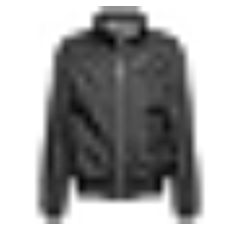

In [21]:
plt.figure()
plt.imshow(temp[0][0].numpy(), cmap=plt.cm.gray_r)
plt.axis("off")